# Linear Regression Starter Kit for Kaggle House Prices 

## Install older version of H2O
* This is a work around for java.lang.ArrayIndexOutOfBoundsException error
* When running glm.predict()

In [1]:
# Use pip to install this version of the H2O Python module
! pip install http://h2o-release.s3.amazonaws.com/h2o/rel-turing/10/Python/h2o-3.10.0.10-py2.py3-none-any.whl

## Imports and inits

In [2]:
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch 
h2o.init() # give h2o as much memory as possible
h2o.no_progress() # turn off h2o progress bars

import numpy as np
import pandas as pd

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_112"; Java(TM) SE Runtime Environment (build 1.8.0_112-b16); Java HotSpot(TM) 64-Bit Server VM (build 25.112-b16, mixed mode)
  Starting server from /Users/phall/anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpbbsjab8d
  JVM stdout: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpbbsjab8d/h2o_phall_started_from_python.out
  JVM stderr: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpbbsjab8d/h2o_phall_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster version:,3.10.0.10
H2O cluster version age:,6 months and 26 days !!!
H2O cluster name:,H2O_from_python_phall_argeao
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


## Import data

In [3]:
train = h2o.import_file('../data/train.csv')
test = h2o.import_file('../data/test.csv')

#### Determine data types

In [4]:
def get_type_lists(frame=train, rejects=['Id', 'SalePrice']):

    """Creates lists of numeric and categorical variables.
    
    :param frame: The frame from which to determine types.
    :param rejects: Variable names not to be included in returned lists.
    :return: Tuple of lists for numeric and categorical variables in the frame.
    
    """
    
    nums, cats = [], []
    for key, val in frame.types.items():
        if key not in rejects:
            if val == 'enum':
                cats.append(key)
            else: 
                nums.append(key)
                
    print('Numeric =', nums)                
    print()
    print('Categorical =', cats)
    
    return nums, cats

In [5]:
original_nums, cats = get_type_lists()

Numeric = ['FullBath', 'MoSold', 'OverallCond', 'BedroomAbvGr', '1stFlrSF', 'GrLivArea', 'ScreenPorch', 'KitchenAbvGr', 'BsmtFinSF2', 'OverallQual', 'GarageYrBlt', 'GarageArea', 'BsmtFullBath', 'TotalBsmtSF', 'BsmtUnfSF', 'GarageCars', 'WoodDeckSF', 'PoolArea', 'EnclosedPorch', 'LowQualFinSF', 'LotArea', 'HalfBath', 'YrSold', 'BsmtFinSF1', 'MSSubClass', 'MasVnrArea', 'YearRemodAdd', '2ndFlrSF', 'YearBuilt', '3SsnPorch', 'MiscVal', 'Fireplaces', 'TotRmsAbvGrd', 'BsmtHalfBath', 'OpenPorchSF', 'LotFrontage']

Categorical = ['HeatingQC', 'ExterQual', 'Condition2', 'ExterCond', 'Exterior2nd', 'Neighborhood', 'BldgType', 'PoolQC', 'GarageFinish', 'LotShape', 'SaleCondition', 'BsmtFinType1', 'SaleType', 'Heating', 'Utilities', 'Exterior1st', 'KitchenQual', 'Alley', 'BsmtFinType2', 'CentralAir', 'Electrical', 'Street', 'LandContour', 'BsmtExposure', 'GarageType', 'PavedDrive', 'Fence', 'BsmtCond', 'RoofMatl', 'Foundation', 'FireplaceQu', 'LotConfig', 'Functional', 'MSZoning', 'LandSlope', 'Roo

## Split into to train and validation (before doing data prep!!!)

In [6]:
train, valid = train.split_frame([0.7], seed=12345)
print(train.shape)
print(valid.shape)

(1001, 81)
(459, 81)


## Impute numeric missing

In [7]:
# median usually better than mean
# (_ signifies temporary throw-away variable, used to suppress output)
_ = train[['MasVnrArea', 'GarageYrBlt', 'LotFrontage']].impute(method='median')
_ = valid[['MasVnrArea', 'GarageYrBlt', 'LotFrontage']].impute(method='median')
_ = test[['BsmtHalfBath', 'BsmtFinSF1', 'BsmtFullBath', 'BsmtFinSF2', 'BsmtUnfSF', 'MasVnrArea', 
          'GarageYrBlt', 'LotFrontage', 'GarageCars', 'TotalBsmtSF', 'GarageArea']].impute(method='median')

## Encode categorical vars using shrunken averages
http://helios.mm.di.uoa.gr/~rouvas/ssi/sigkdd/sigkdd.vol3.1/barreca.ps

In [8]:
def target_encoder(training_frame, test_frame, x, y, lambda_=0.15, threshold=150, test=False):

    """ Applies simple target encoding to categorical variables.

    :param training_frame: Training frame which to create target means and to be encoded.
    :param test_frame: Test frame to be encoded using information from training frame.
    :param x: Name of input variable to be encoded.
    :param y: Name of target variable to use for encoding.
    :param lambda_: Balance between level mean and overall mean for small groups.
    :param threshold: Number below which a level is considered small enough to be shrunken.
    :param test: Whether or not to print the row_val_dict for testing purposes.
    :return: Tuple of encoded variable from train and test set as H2OFrames.

    """

    # convert to pandas
    trdf = training_frame.as_data_frame().loc[:, [x,y]] # df
    tss = test_frame.as_data_frame().loc[:, x]          # series


    # create dictionary of level:encode val

    encode_name = x + '_Tencode'
    overall_mean = trdf[y].mean()
    row_val_dict = {}

    for level in trdf[x].unique():
        level_df = trdf[trdf[x] == level][y]
        level_n = level_df.shape[0]
        level_mean = level_df.mean()
        if level_n >= threshold:
            row_val_dict[level] = level_mean
        else:
            row_val_dict[level] = ((1 - lambda_) * level_mean) +\
                                  (lambda_ * overall_mean)

    row_val_dict[np.nan] = overall_mean # handle missing values

    if test:
        print(row_val_dict)

    # apply the transform to training data
    trdf[encode_name] = trdf[x].apply(lambda i: row_val_dict[i])

    # apply the transform to test data
    tsdf = pd.DataFrame(columns=[x, encode_name])
    tsdf[x] = tss
    tsdf.loc[:, encode_name] = overall_mean # handle previously unseen values
    # handle values that are seen in tsdf but not row_val_dict
    for i, col_i in enumerate(tsdf[x]):
        try:
            row_val_dict[col_i]
        except:
            # a value that appeared in tsdf isn't in the row_val_dict so just
            # make it the overall_mean
            row_val_dict[col_i] = overall_mean
    tsdf[encode_name] = tsdf[x].apply(lambda i: row_val_dict[i])


    # convert back to H2O

    trdf = h2o.H2OFrame(trdf[encode_name].as_matrix())
    trdf.columns = [encode_name]

    tsdf = h2o.H2OFrame(tsdf[encode_name].as_matrix())
    tsdf.columns = [encode_name]

    return (trdf, tsdf)


#### Execute encoding

In [9]:
total = len(cats)
for i, var in enumerate(cats):
    
    tr_enc, _ = target_encoder(train, test, var, 'SalePrice')
    v_enc, ts_enc = target_encoder(valid, test, var, 'SalePrice')
    
    print('Encoding: ' + var + ' (' + str(i+1) + '/' + str(total) + ') ...')

    train = train.cbind(tr_enc)
    valid = valid.cbind(v_enc)
    test = test.cbind(ts_enc)    
    
print('Done.')

Encoding: HeatingQC (1/43) ...
Encoding: ExterQual (2/43) ...
Encoding: Condition2 (3/43) ...
Encoding: ExterCond (4/43) ...
Encoding: Exterior2nd (5/43) ...
Encoding: Neighborhood (6/43) ...
Encoding: BldgType (7/43) ...
Encoding: PoolQC (8/43) ...
Encoding: GarageFinish (9/43) ...
Encoding: LotShape (10/43) ...
Encoding: SaleCondition (11/43) ...
Encoding: BsmtFinType1 (12/43) ...
Encoding: SaleType (13/43) ...
Encoding: Heating (14/43) ...
Encoding: Utilities (15/43) ...
Encoding: Exterior1st (16/43) ...
Encoding: KitchenQual (17/43) ...
Encoding: Alley (18/43) ...
Encoding: BsmtFinType2 (19/43) ...
Encoding: CentralAir (20/43) ...
Encoding: Electrical (21/43) ...
Encoding: Street (22/43) ...
Encoding: LandContour (23/43) ...
Encoding: BsmtExposure (24/43) ...
Encoding: GarageType (25/43) ...
Encoding: PavedDrive (26/43) ...
Encoding: Fence (27/43) ...
Encoding: BsmtCond (28/43) ...
Encoding: RoofMatl (29/43) ...
Encoding: Foundation (30/43) ...
Encoding: FireplaceQu (31/43) ...
Enc

#### Redefine numerics and explore

In [10]:
encoded_nums, cats = get_type_lists(frame=train)

Numeric = ['Condition2_Tencode', 'MasVnrArea', 'FullBath', 'MiscFeature_Tencode', 'MoSold', 'OverallCond', 'BedroomAbvGr', '1stFlrSF', 'Alley_Tencode', 'Foundation_Tencode', 'GrLivArea', 'ScreenPorch', 'BsmtExposure_Tencode', 'KitchenAbvGr', 'BsmtFinSF2', 'OverallQual', 'Fireplaces', 'LotShape_Tencode', 'GarageType_Tencode', 'GarageYrBlt', 'BsmtFinType1_Tencode', 'HeatingQC_Tencode', 'GarageArea', 'Utilities_Tencode', 'Fence_Tencode', 'TotalBsmtSF', 'BsmtCond_Tencode', 'MasVnrType_Tencode', 'SaleCondition_Tencode', 'Functional_Tencode', 'GarageFinish_Tencode', 'BsmtUnfSF', 'ExterQual_Tencode', 'RoofStyle_Tencode', 'BsmtQual_Tencode', 'LandSlope_Tencode', 'WoodDeckSF', 'BldgType_Tencode', 'PoolArea', 'EnclosedPorch', 'KitchenQual_Tencode', 'BsmtFullBath', 'BsmtFinType2_Tencode', 'LowQualFinSF', 'GarageCars', 'HalfBath', 'Neighborhood_Tencode', 'LandContour_Tencode', 'Condition1_Tencode', 'LotArea', 'PoolQC_Tencode', 'BsmtFinSF1', 'GarageQual_Tencode', 'MSSubClass', 'CentralAir_Tencode',

In [11]:
print('Imputed and encoded numeric training data:')
train[encoded_nums].describe() #79 numeric columns w/ no missing
print('--------------------------------------------------------------------------------')
print('Imputed and encoded numeric validation data:')
valid[encoded_nums].describe() #79 numeric columns w/ no missing
print('--------------------------------------------------------------------------------')
print('Imputed and encoded numeric test data:')
test[encoded_nums].describe() #79 numeric columns w/ no missing

Imputed and encoded numeric training data:
Rows:1001
Cols:79




,Condition2_Tencode,MasVnrArea,FullBath,MiscFeature_Tencode,MoSold,OverallCond,BedroomAbvGr,1stFlrSF,Alley_Tencode,Foundation_Tencode,GrLivArea,ScreenPorch,BsmtExposure_Tencode,KitchenAbvGr,BsmtFinSF2,OverallQual,Fireplaces,LotShape_Tencode,GarageType_Tencode,GarageYrBlt,BsmtFinType1_Tencode,HeatingQC_Tencode,GarageArea,Utilities_Tencode,Fence_Tencode,TotalBsmtSF,BsmtCond_Tencode,MasVnrType_Tencode,SaleCondition_Tencode,Functional_Tencode,GarageFinish_Tencode,BsmtUnfSF,ExterQual_Tencode,RoofStyle_Tencode,BsmtQual_Tencode,LandSlope_Tencode,WoodDeckSF,BldgType_Tencode,PoolArea,EnclosedPorch,KitchenQual_Tencode,BsmtFullBath,BsmtFinType2_Tencode,LowQualFinSF,GarageCars,HalfBath,Neighborhood_Tencode,LandContour_Tencode,Condition1_Tencode,LotArea,PoolQC_Tencode,BsmtFinSF1,GarageQual_Tencode,MSSubClass,CentralAir_Tencode,YearRemodAdd,2ndFlrSF,Electrical_Tencode,YearBuilt,PavedDrive_Tencode,GarageCond_Tencode,3SsnPorch,MiscVal,FireplaceQu_Tencode,Exterior1st_Tencode,Heating_Tencode,TotRmsAbvGrd,HouseStyle_Tencode,BsmtHalfBath,Exterior2nd_Tencode,OpenPorchSF,ExterCond_Tencode,SaleType_Tencode,RoofMatl_Tencode,YrSold,LotConfig_Tencode,Street_Tencode,MSZoning_Tencode,LotFrontage
type,real,real,int,real,int,int,int,int,real,real,int,int,real,int,int,int,int,real,real,real,real,real,int,real,real,int,real,real,real,real,real,int,real,real,real,real,int,real,int,int,real,int,real,int,int,int,real,real,real,int,real,int,real,int,real,int,int,real,int,real,real,int,int,real,real,real,int,real,int,real,int,real,real,real,int,real,real,real,real
mins,108075.79385614385,0.0,0.0,140375.79385614386,1.0,2.0,0.0,480.0,128075.200999001,121726.89385614387,480.0,0.0,167645.4123076923,0.0,0.0,2.0,0.0,163944.59385614382,125174.9605228105,1908.0,150410.4464877228,135668.69902855766,0.0,144200.79385614386,141306.73814185814,0.0,84275.79385614385,155578.6188811189,115832.04385614385,110059.12718947718,141354.57177033494,0.0,116078.96885614384,161577.2224275724,121216.12093947716,181486.5182747485,0.0,138273.46052281052,0.0,0.0,124936.94820396995,0.0,154536.9355228105,0.0,0.0,0.0,109690.79385614385,145140.16285614387,134468.29385614386,1300.0,182171.95904095902,0.0,96813.29385614385,20.0,119608.23368665231,1950.0,0.0,84275.79385614385,1875.0,129253.89464979463,112070.79385614385,0.0,0.0,141462.34885614386,78325.79385614385,93469.96052281052,3.0,118907.22242757239,0.0,129978.23968947721,0.0,122047.14941169939,125968.29385614385,143775.79385614386,2006.0,176473.2899159664,146350.10385614386,78614.79385614385,21.0
mean,182224.4420403772,106.91146881287727,1.5744255744255744,181198.19224147475,6.362637362637362,5.583416583416583,2.871128871128871,1172.0889110889111,180171.38546862727,183119.90242260235,1519.8011988011988,14.763236763236764,182844.62529074325,1.046953046953047,41.64935064935065,6.1448551448551445,0.6203796203796204,181993.92786324563,185255.62265751234,1978.734522560336,185645.79515235015,182409.7085632649,477.46853146853147,182178.65314071544,177450.87030976015,1063.2387612387613,184043.11900766566,180574.40004970055,181541.32494458588,182576.24533688094,185712.8721618042,575.99000999001,181095.69602749898,182159.0086938536,182245.41278741238,182145.0556687069,91.07392607392607,182849.79797600003,3.3766233766233764,21.257742257742258,180810.97023994988,0.42657342657342656,184056.75787594018,5.9250749250749255,1.7932067932067932,0.38161838161838163,182171.95904095905,182186.73299732237,182645.11776425372,10628.262737262738,182802.82568320786,445.5994005994006,186018.3297154893,57.08791208791209,182822.70708043204,1985.138861138861,341.7872127872128,182952.64128239392,1972.2987012987012,182908.18055950044,186002.74671607107,3.4565434565434567,39.684315684315685,200266.80114860163,183565.71379414792,182323.57985955098,6.512487512487512,183188.25635258848,0.059940059940059943,183994.52609268852,44.92407592407592,182637.23505924645,181180.3311701286,182033.94005549894,2007.828171828172,181772.16118142597,182203.5349842964,183387.92640181992,70.599756

--------------------------------------------------------------------------------
Imputed and encoded numeric validation data:
Rows:459
Cols:79




,Condition2_Tencode,MasVnrArea,FullBath,MiscFeature_Tencode,MoSold,OverallCond,BedroomAbvGr,1stFlrSF,Alley_Tencode,Foundation_Tencode,GrLivArea,ScreenPorch,BsmtExposure_Tencode,KitchenAbvGr,BsmtFinSF2,OverallQual,Fireplaces,LotShape_Tencode,GarageType_Tencode,GarageYrBlt,BsmtFinType1_Tencode,HeatingQC_Tencode,GarageArea,Utilities_Tencode,Fence_Tencode,TotalBsmtSF,BsmtCond_Tencode,MasVnrType_Tencode,SaleCondition_Tencode,Functional_Tencode,GarageFinish_Tencode,BsmtUnfSF,ExterQual_Tencode,RoofStyle_Tencode,BsmtQual_Tencode,LandSlope_Tencode,WoodDeckSF,BldgType_Tencode,PoolArea,EnclosedPorch,KitchenQual_Tencode,BsmtFullBath,BsmtFinType2_Tencode,LowQualFinSF,GarageCars,HalfBath,Neighborhood_Tencode,LandContour_Tencode,Condition1_Tencode,LotArea,PoolQC_Tencode,BsmtFinSF1,GarageQual_Tencode,MSSubClass,CentralAir_Tencode,YearRemodAdd,2ndFlrSF,Electrical_Tencode,YearBuilt,PavedDrive_Tencode,GarageCond_Tencode,3SsnPorch,MiscVal,FireplaceQu_Tencode,Exterior1st_Tencode,Heating_Tencode,TotRmsAbvGrd,HouseStyle_Tencode,BsmtHalfBath,Exterior2nd_Tencode,OpenPorchSF,ExterCond_Tencode,SaleType_Tencode,RoofMatl_Tencode,YrSold,LotConfig_Tencode,Street_Tencode,MSZoning_Tencode,LotFrontage
type,real,real,int,real,int,int,int,int,real,real,int,int,real,int,int,int,int,real,real,real,real,real,int,real,real,int,real,real,real,real,real,int,real,real,real,real,int,real,int,int,real,int,real,int,int,int,real,real,real,int,real,int,real,int,real,int,int,real,int,real,real,int,int,real,real,real,int,real,int,real,int,real,real,real,int,real,real,real,real
mins,84954.02450980392,0.0,0.0,73479.02450980392,1.0,1.0,0.0,334.0,134607.54723707662,110363.31736694675,334.0,0.0,161376.63366336632,1.0,0.0,1.0,0.0,163981.4191419142,111434.07450980392,1900.0,146338.19117647054,100679.02450980392,0.0,178193.4967320261,133419.96200980392,0.0,78579.02450980392,131576.52450980392,143816.52450980392,84954.02450980392,143948.79679144386,0.0,91042.14950980392,139864.02450980392,134771.7517825312,175531.83179723503,0.0,128987.56617647059,0.0,0.0,105130.89950980392,0.0,145091.52450980392,0.0,0.0,0.0,112866.7168174962,163075.56297134238,150223.0311764706,1491.0,178193.4967320261,0.0,134853.20367647058,20.0,111601.52450980392,1950.0,0.0,100143.52450980392,1872.0,114840.96895424835,118776.94117647059,0.0,0.0,133191.52450980392,96429.02450980392,77729.02450980392,2.0,122402.59593837534,0.0,106204.02450980392,0.0,91754.02450980392,107734.02450980392,175904.02450980392,2006.0,165751.57330498463,95579.02450980392,118217.35784313723,21.0
mean,178197.18104147978,96.68340611353712,1.5446623093681917,177409.66351972884,6.233115468409586,5.557734204793029,2.8562091503267975,1141.9912854030501,176164.9969256838,179041.90369302404,1506.004357298475,15.710239651416122,178366.110436157,1.0457516339869282,57.23529411764706,6.0,0.5969498910675382,176786.22238241704,185134.53079371178,1977.9953051643192,180031.30962236744,180663.6615169379,463.1917211328976,178193.49673202608,173941.1787702735,1044.7603485838779,180413.2355397497,176108.20460862629,177335.48292323467,178425.73264556366,181122.03431372548,548.1590413943355,174940.2994916485,177381.1458157119,179069.59942970652,177815.9926203597,101.15904139433552,178649.14910504507,1.411764705882353,23.47276688453159,177298.2844312017,0.4226579520697168,180587.69974155238,5.668845315904139,1.710239651416122,0.38562091503267976,178193.49673202613,177854.22806185653,178617.62590029472,10273.808278867102,178198.69396030012,439.36601307189545,184195.2038275876,56.48148148148148,179115.18492887347,1984.2701525054467,358.3442265795207,179083.62772865137,1969.0196078431372,179002.9605814003,184432.0126553889,3.30718954248366,51.78649237472767,194587.7731541999,179651.10523303002,178371.04867785895,6.529411764705882,177648.76674783204,0.05228758169934641,179728.60882139349,50.446623093681914,178484.55631381093,177239.63702422145,177969.71943483275,2007.7886710239652,178163.26637404418,178225.25931265755,179328.32668845312,68.85751978891821
maxs,302979.0

--------------------------------------------------------------------------------
Imputed and encoded numeric test data:
Rows:1459
Cols:79




,Condition2_Tencode,MasVnrArea,FullBath,MiscFeature_Tencode,MoSold,OverallCond,BedroomAbvGr,1stFlrSF,Alley_Tencode,Foundation_Tencode,GrLivArea,ScreenPorch,BsmtExposure_Tencode,KitchenAbvGr,BsmtFinSF2,OverallQual,Fireplaces,LotShape_Tencode,GarageType_Tencode,GarageYrBlt,BsmtFinType1_Tencode,HeatingQC_Tencode,GarageArea,Utilities_Tencode,Fence_Tencode,TotalBsmtSF,BsmtCond_Tencode,MasVnrType_Tencode,SaleCondition_Tencode,Functional_Tencode,GarageFinish_Tencode,BsmtUnfSF,ExterQual_Tencode,RoofStyle_Tencode,BsmtQual_Tencode,LandSlope_Tencode,WoodDeckSF,BldgType_Tencode,PoolArea,EnclosedPorch,KitchenQual_Tencode,BsmtFullBath,BsmtFinType2_Tencode,LowQualFinSF,GarageCars,HalfBath,Neighborhood_Tencode,LandContour_Tencode,Condition1_Tencode,LotArea,PoolQC_Tencode,BsmtFinSF1,GarageQual_Tencode,MSSubClass,CentralAir_Tencode,YearRemodAdd,2ndFlrSF,Electrical_Tencode,YearBuilt,PavedDrive_Tencode,GarageCond_Tencode,3SsnPorch,MiscVal,FireplaceQu_Tencode,Exterior1st_Tencode,Heating_Tencode,TotRmsAbvGrd,HouseStyle_Tencode,BsmtHalfBath,Exterior2nd_Tencode,OpenPorchSF,ExterCond_Tencode,SaleType_Tencode,RoofMatl_Tencode,YrSold,LotConfig_Tencode,Street_Tencode,MSZoning_Tencode,LotFrontage
type,real,real,int,real,int,int,int,int,real,real,int,int,real,int,real,int,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,int,real,int,int,real,real,real,int,real,int,real,real,real,int,real,real,real,int,real,int,int,real,int,real,real,int,int,real,real,real,int,real,real,real,int,real,real,real,int,real,real,real,real
mins,127029.02450980392,0.0,0.0,73479.02450980392,1.0,1.0,0.0,407.0,134607.54723707662,110363.31736694675,407.0,0.0,161376.63366336632,0.0,0.0,1.0,0.0,163981.4191419142,111434.07450980392,1895.0,146338.19117647054,100679.02450980392,0.0,178193.4967320261,133419.96200980392,0.0,78579.02450980392,131576.52450980392,143816.52450980392,84954.02450980392,143948.79679144386,0.0,91042.14950980392,139864.02450980392,134771.7517825312,175531.83179723503,0.0,128987.56617647059,0.0,0.0,105130.89950980392,0.0,145091.52450980392,0.0,0.0,0.0,112866.7168174962,163075.56297134238,150223.0311764706,1470.0,178193.4967320261,0.0,134853.20367647058,20.0,111601.52450980392,1950.0,0.0,100143.52450980392,1879.0,114840.96895424835,118776.94117647059,0.0,0.0,133191.52450980392,96429.02450980392,77729.02450980392,3.0,122402.59593837534,0.0,106204.02450980392,0.0,91754.02450980392,107734.02450980392,175904.02450980392,2006.0,165751.57330498463,95579.02450980392,118217.35784313723,21.0
mean,178369.39980873463,100.70914127423823,1.570938999314599,177606.24421888925,6.104180945853324,5.5538039753255655,2.8540095956134337,1156.534612748458,176172.85149770897,181006.2901857593,1486.0459218642907,17.064427690198766,179354.8610184363,1.0424948594928032,52.61934156378601,6.078821110349555,0.5812200137080192,176844.0836371834,186339.7089378328,1977.7212165097756,182091.99147253158,182227.81273899964,472.7688614540466,178193.4967320261,174246.9783571091,1046.1179698216736,179283.61725237884,178207.07986924512,176492.09637795313,178383.03720943845,180987.1789957136,554.2949245541838,177673.68837649448,177370.7037166422,181062.10689687656,177395.21920765378,93.17477724468814,178370.36965515942,1.7443454420836186,24.24331734064427,179340.3962464452,0.4344543582704186,180689.57815766838,3.5435229609321452,1.7661179698216736,0.3776559287183002,179660.9318538107,179174.226337526,179939.77372747526,9819.161069225496,178193.4967320261,439.2037037037037,182567.66333366183,57.37834132967786,179789.60281035837,1983.6627827278958,325.9677861549006,180126.1193152811,1971.357779300891,177090.15440559445,184620.93755108098,1.794379712131597,58.16792323509253,194452.82035270397,179810.686881209,179140.34833949362,6.385195339273475,176296.0327526845,0.06520247083047358,180995.23531825157,48.3139136394791,178138.29247727426,175933.10715345875,176751.75320615337,2007.7697052775875,178278.00897433652,178065.09267032953,179232.09043019178,68.5803571428

In [12]:
# Check Neighborhood_Tencode

print(test[0:5, ['Neighborhood', 'Neighborhood_Tencode']])
_, _ = target_encoder(valid, test, 'Neighborhood', 'SalePrice', test=True)
del _

# NAmes   152080
# NAmes   152080
# Gilbert 191808
# Gilbert 191808
# StoneBr 288359

Neighborhood,Neighborhood_Tencode
NAmes,152080
NAmes,152080
Gilbert,191808
Gilbert,191808
StoneBr,288359



{'IDOTRR': 112866.71681749621, nan: 178193.49673202613, 'OldTown': 139863.03613771088, 'NridgHt': 284073.1545098039, 'NoRidge': 273948.2552790347, 'Somerst': 227656.9671023965, 'NPkVill': 147641.52450980392, 'ClearCr': 207949.02450980392, 'Gilbert': 191808.0596949891, 'Sawyer': 143162.40700980392, 'Veenker': 243734.02450980392, 'Blmngtn': 210845.6545098039, 'Timber': 260109.74673202613, 'MeadowV': 113131.52450980392, 'StoneBr': 288359.0245098039, 'SWISU': 156269.02450980392, 'NAmes': 152080.32258672698, 'CollgCr': 190019.77971813726, 'Mitchel': 169316.52450980392, 'NWAmes': 184610.14950980392, 'BrkSide': 129965.77450980392, 'Crawfor': 216008.84593837534, 'SawyerW': 189097.7776348039, 'BrDale': 116064.02450980392, 'Edwards': 126241.13989441929}


## Create combination features

In [13]:
def feature_combiner(training_frame, test_frame, nums):
    
    """ Combines numeric features using simple arithmatic operations.
    
    :param training_frame: Training frame from which to generate features and onto which generated 
                           feeatures will be cbound.
    :param test_frame: Test frame from which to generate features and onto which generated 
                       feeatures will be cbound.
    :param nums: List of original numeric features from which to generate combined features.
    
    """

    total = len(nums)
    
    # convert to pandas
    train_df = training_frame.as_data_frame()
    test_df = test_frame.as_data_frame()
    
    for i, col_i in enumerate(nums):
        
        print('Combining: ' + col_i + ' (' + str(i+1) + '/' + str(total) + ') ...')        
        
        for j, col_j in enumerate(nums):
            
            # don't repeat (i*j = j*i)
            if i < j:
                
                # convert to pandas
                col_i_train_df = train_df[col_i]
                col_j_train_df = train_df[col_j]
                col_i_test_df = test_df[col_i]
                col_j_test_df = test_df[col_j] 

                # multiply, convert back to h2o
                train_df[str(col_i + '|' + col_j)] = col_i_train_df.values*col_j_train_df.values
                test_df[str(col_i + '|' + col_j)] = col_i_test_df.values*col_j_test_df.values
                
    print('Done.')
    
    # convert back to h2o
    
    print('Converting to H2OFrame ...')
    
    training_frame = h2o.H2OFrame(train_df)
    training_frame.columns = list(train_df)
    test_frame = h2o.H2OFrame(test_df)
    test_frame.columns = list(test_df)
    
    print('Done.')
    print()
    
    # conserve memory 
    del train_df
    del test_df 
    
    return training_frame, test_frame


In [14]:
train, _ = feature_combiner(train, test, encoded_nums)
valid, test = feature_combiner(valid, test, encoded_nums)

Combining: Condition2_Tencode (1/79) ...
Combining: MasVnrArea (2/79) ...
Combining: FullBath (3/79) ...
Combining: MiscFeature_Tencode (4/79) ...
Combining: MoSold (5/79) ...
Combining: OverallCond (6/79) ...
Combining: BedroomAbvGr (7/79) ...
Combining: 1stFlrSF (8/79) ...
Combining: Alley_Tencode (9/79) ...
Combining: Foundation_Tencode (10/79) ...
Combining: GrLivArea (11/79) ...
Combining: ScreenPorch (12/79) ...
Combining: BsmtExposure_Tencode (13/79) ...
Combining: KitchenAbvGr (14/79) ...
Combining: BsmtFinSF2 (15/79) ...
Combining: OverallQual (16/79) ...
Combining: Fireplaces (17/79) ...
Combining: LotShape_Tencode (18/79) ...
Combining: GarageType_Tencode (19/79) ...
Combining: GarageYrBlt (20/79) ...
Combining: BsmtFinType1_Tencode (21/79) ...
Combining: HeatingQC_Tencode (22/79) ...
Combining: GarageArea (23/79) ...
Combining: Utilities_Tencode (24/79) ...
Combining: Fence_Tencode (25/79) ...
Combining: TotalBsmtSF (26/79) ...
Combining: BsmtCond_Tencode (27/79) ...
Combin

#### Redefine numerics and explore

In [15]:
encoded_combined_nums, cats = get_type_lists(frame=train)

Numeric = ['GarageType_Tencode|PavedDrive_Tencode', 'TotalBsmtSF|2ndFlrSF', 'BsmtFinType1_Tencode|FireplaceQu_Tencode', 'GarageType_Tencode|MSZoning_Tencode', 'Fireplaces|3SsnPorch', 'Neighborhood_Tencode|ExterCond_Tencode', 'GrLivArea|MSSubClass', 'ScreenPorch|Fireplaces', 'EnclosedPorch|LowQualFinSF', 'GarageFinish_Tencode|ExterCond_Tencode', 'Functional_Tencode|BsmtFinType2_Tencode', 'Fireplaces|GarageFinish_Tencode', 'KitchenAbvGr|KitchenQual_Tencode', 'BsmtUnfSF|GarageCond_Tencode', 'GarageArea|BsmtCond_Tencode', 'PavedDrive_Tencode|FireplaceQu_Tencode', 'BedroomAbvGr|Heating_Tencode', 'BsmtFinType1_Tencode|3SsnPorch', 'GrLivArea|MSZoning_Tencode', 'PoolArea|MiscVal', 'Fence_Tencode|BsmtFinSF1', 'PavedDrive_Tencode|RoofMatl_Tencode', 'OverallQual|Condition1_Tencode', 'WoodDeckSF|BldgType_Tencode', 'HeatingQC_Tencode', 'GrLivArea|Exterior1st_Tencode', 'Alley_Tencode|ScreenPorch', 'Condition2_Tencode|KitchenQual_Tencode', 'SaleCondition_Tencode', 'GarageType_Tencode|Street_Tencode',

In [16]:
# check number of created variables is correct
# 1 id column, 1 target column, 79 original + encoded numeric columns, 43 original categorical variables
# sum(range(1, 79)) combined variables
print(train.shape == (1001, sum(range(1, 79), (79 + 43 + 1 + 1))))
print(test.shape == (1459, sum(range(1, 79), (79 + 43 + 1))))

True
True


In [17]:
# check multiplication for a random column
ridx = np.random.choice(sum(range(1, 79)))
combined_only = [name for name in encoded_combined_nums if name not in encoded_nums]
combined_check_vars = combined_only[ridx].split('|')
combined_check_vars.append(combined_only[ridx])

print(train[736, combined_check_vars])
print(test[637, combined_check_vars])

print(train[736, combined_check_vars[0]]*train[736, combined_check_vars[1]])
print(test[637, combined_check_vars[0]]*test[637, combined_check_vars[1]])

LotArea,3SsnPorch,LotArea|3SsnPorch
11275,0,0


LotArea,3SsnPorch,LotArea|3SsnPorch
9000,0,0



0.0
0.0


## Train constituent models (for inspection purposes)

In [18]:
h2o.show_progress()                                          # turn on progress bars
from h2o.estimators.glm import H2OGeneralizedLinearEstimator # import GLM models
from h2o.grid.grid_search import H2OGridSearch               # grid search

SalePrice
12.2477
12.109
12.3172


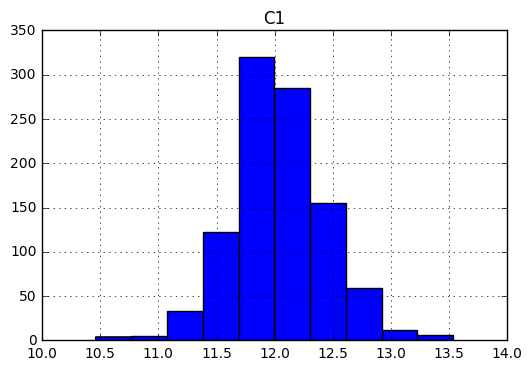

In [19]:
# Check log transform - looks good
%matplotlib inline
train['SalePrice'].log().as_data_frame().hist()

# Execute log transform
train['SalePrice'] = train['SalePrice'].log()
valid['SalePrice'] = valid['SalePrice'].log()
print(train[0:3, 'SalePrice'])

#### Split training data

In [20]:
base_train, stack_train = train.split_frame([0.5], seed=12345)
base_valid, stack_valid = valid.split_frame([0.5], seed=12345)
print(base_train.shape)
print(base_valid.shape)
print(stack_train.shape)
print(stack_valid.shape)

(504, 3205)
(230, 3205)
(497, 3205)
(229, 3205)


#### Define model with grid search function

In [21]:
def glm_grid(X, y, train, valid):
    
    """ Wrapper function for penalized GLM with alpha and lambda search.
    
    :param X: List of inputs.
    :param y: Name of target variable.
    :param train: Name of training H2OFrame.
    :param valid: Name of validation H2OFrame.
    :return: Best H2Omodel from H2OGeneralizedLinearEstimator

    """
    
    alpha_opts = [0.01, 0.25, 0.5, 0.99] # always keep some L2
    hyper_parameters = {"alpha":alpha_opts}

    # initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(
            family="gaussian",
            lambda_search=True,
            seed=12345),
        hyper_params=hyper_parameters)
    
    # train grid
    grid.train(y=y,
               x=X, 
               training_frame=train,
               validation_frame=valid)

    # show grid search results
    print(grid.show())

    best = grid.get_grid()[0]
    print(best)
    
    # plot top frame values
    yhat_frame = valid.cbind(best.predict(valid))
    print(yhat_frame[0:10, [y, 'predict']])

    # plot sorted predictions
    yhat_frame_df = yhat_frame[[y, 'predict']].as_data_frame()
    yhat_frame_df.sort_values(by='predict', inplace=True)
    yhat_frame_df.reset_index(inplace=True, drop=True)
    _ = yhat_frame_df.plot(title='Ranked Predictions Plot')
    
    # select best model
    return best


## Train base level models

#### First model on original numeric inputs

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.99]  Grid_GLM_py_287_sid_83be_model_python_1496514712697_1_model_3   
1     [0.5]  Grid_GLM_py_287_sid_83be_model_python_1496514712697_1_model_2   
2    [0.25]  Grid_GLM_py_287_sid_83be_model_python_1496514712697_1_model_1   
3    [0.01]  Grid_GLM_py_287_sid_83be_model_python_1496514712697_1_model_0   

   residual_deviance  
0  4.025940991543426  
1  4.037235202840883  
2  4.058507339499796  
3  4.491994155264081  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_287_sid_83be_model_python_1496514712697_1_model_3
GLM Model: summary



,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,gaussian,identity,"Elastic Net (alpha = 0.99, lambda = 0.006584 )","nlambda = 100, lambda.max = 0.3277, lambda.min = 0.006584, lambda.1se = -1.0",36,24,0,py_287_sid_83be




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.021564404839388217
RMSE: 0.146848237440523
MAE: 0.09686367637083063
RMSLE: 0.011364228341693757
R^2: 0.862319569887144
Mean Residual Deviance: 0.021564404839388217
Null degrees of freedom: 503
Residual degrees of freedom: 479
Null deviance: 78.93975948609085
Residual deviance: 10.868460039051662
AIC: -451.41242737800724

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 0.017504091267580114
RMSE: 0.1323030281874913
MAE: 0.09463802529252507
RMSLE: 0.010248815547846181
R^2: 0.8820493204228329
Mean Residual Deviance: 0.017504091267580114
Null degrees of freedom: 229
Residual degrees of freedom: 205
Null deviance: 34.66875782373327
Residual deviance: 4.025940991543426
AIC: -225.71202161711267
Scoring History: 


,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-06-03 14:32:56,0.000 sec,0,.31E0,2,0.1472858,0.1420261
,2017-06-03 14:32:56,0.001 sec,0,.3E0,2,0.1387711,0.1340858
,2017-06-03 14:32:56,0.002 sec,0,.29E0,2,0.1310096,0.1268453
,2017-06-03 14:32:56,0.003 sec,0,.27E0,2,0.1239348,0.1202429
,2017-06-03 14:32:56,0.003 sec,0,.26E0,2,0.1174861,0.1142224
---,---,---,---,---,---,---,---
,2017-06-03 14:32:56,0.116 sec,0,.39E-2,28,0.0211140,0.0177064
,2017-06-03 14:32:56,0.118 sec,0,.38E-2,29,0.0210799,0.0177301
,2017-06-03 14:32:56,0.119 sec,0,.36E-2,30,0.0210495,0.0177502
,2017-06-03 14:32:56,0.121 sec,0,.34E-2,30,0.0210200,0.0177665



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.8494,11.9833
12.2061,12.3454
11.6784,11.6651
11.914,11.8164
12.6758,12.4798
12.861,12.7562
12.1035,12.0074
11.2898,11.3823
11.7714,11.7068
11.5843,11.4633


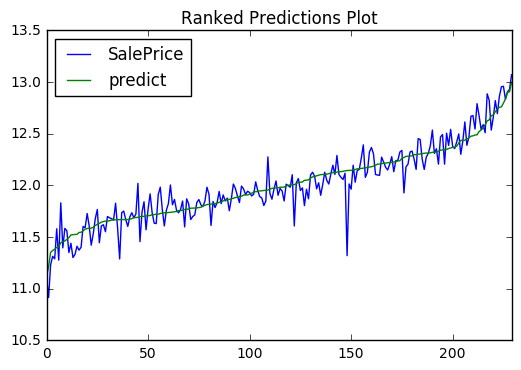

In [22]:
glm0 = glm_grid(original_nums, 'SalePrice', base_train, base_valid)

#### Second model on encoded numeric inputs

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.99]  Grid_GLM_py_287_sid_83be_model_python_1496514712697_2_model_3   
1     [0.5]  Grid_GLM_py_287_sid_83be_model_python_1496514712697_2_model_2   
2    [0.25]  Grid_GLM_py_287_sid_83be_model_python_1496514712697_2_model_1   
3    [0.01]  Grid_GLM_py_287_sid_83be_model_python_1496514712697_2_model_0   

    residual_deviance  
0  3.4901340287134235  
1  3.4921300110517253  
2  3.4997238542795293  
3   3.998123203723189  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_287_sid_83be_model_python_1496514712697_2_model_3
GLM Model: summary



,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,gaussian,identity,"Elastic Net (alpha = 0.99, lambda = 0.006285 )","nlambda = 100, lambda.max = 0.3277, lambda.min = 0.006285, lambda.1se = -1.0",78,48,0,py_287_sid_83be




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.015094165358452758
RMSE: 0.12285831416087703
MAE: 0.0853879096692911
RMSLE: 0.009548892056318143
R^2: 0.903629560183804
Mean Residual Deviance: 0.015094165358452758
Null degrees of freedom: 503
Residual degrees of freedom: 455
Null deviance: 78.93975948609085
Residual deviance: 7.60745934066019
AIC: -583.207251537172

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 0.015174495777014884
RMSE: 0.12318480335258439
MAE: 0.090956608392666
RMSLE: 0.009524082982279752
R^2: 0.8977472145352223
Mean Residual Deviance: 0.015174495777014884
Null degrees of freedom: 229
Residual degrees of freedom: 181
Null deviance: 34.66875782373327
Residual deviance: 3.4901340287134235
AIC: -210.56028378064303
Scoring History: 


,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-06-03 14:32:58,0.000 sec,0,.31E0,2,0.1472858,0.1420261
,2017-06-03 14:32:58,0.001 sec,0,.3E0,2,0.1387711,0.1340858
,2017-06-03 14:32:58,0.002 sec,0,.29E0,2,0.1310096,0.1268453
,2017-06-03 14:32:58,0.003 sec,0,.27E0,2,0.1239348,0.1202429
,2017-06-03 14:32:58,0.005 sec,0,.26E0,2,0.1174861,0.1142224
---,---,---,---,---,---,---,---
,2017-06-03 14:32:58,0.142 sec,0,.39E-2,53,0.0144191,0.0155881
,2017-06-03 14:32:58,0.144 sec,0,.38E-2,53,0.0143701,0.0156291
,2017-06-03 14:32:58,0.146 sec,0,.36E-2,54,0.0143235,0.0156864
,2017-06-03 14:32:58,0.148 sec,0,.34E-2,54,0.0142814,0.0157581



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.8494,12.113
12.2061,12.2729
11.6784,11.8202
11.914,11.7812
12.6758,12.486
12.861,12.6814
12.1035,11.9299
11.2898,11.3451
11.7714,11.6453
11.5843,11.4851


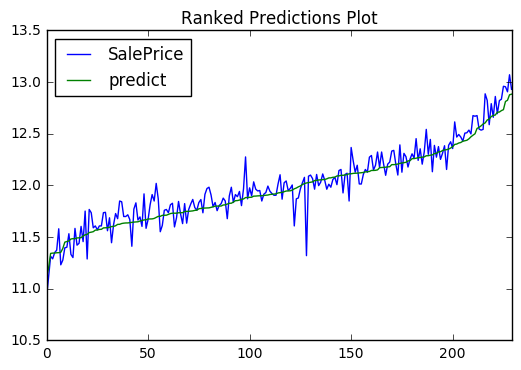

In [23]:
glm1 = glm_grid(encoded_nums, 'SalePrice', base_train, base_valid)

#### Third model on encoded numeric inputs

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.01]  Grid_GLM_py_287_sid_83be_model_python_1496514712697_3_model_0   
1    [0.25]  Grid_GLM_py_287_sid_83be_model_python_1496514712697_3_model_1   
2     [0.5]  Grid_GLM_py_287_sid_83be_model_python_1496514712697_3_model_2   
3    [0.99]  Grid_GLM_py_287_sid_83be_model_python_1496514712697_3_model_3   

    residual_deviance  
0  3.3699520043051416  
1  3.5220183469851305  
2  3.6067172565664762  
3  3.6571556417378868  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_287_sid_83be_model_python_1496514712697_3_model_0
GLM Model: summary



,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,gaussian,identity,"Elastic Net (alpha = 0.01, lambda = 0.552 )","nlambda = 100, lambda.max = 33.09, lambda.min = 0.552, lambda.1se = -1.0",3148,700,0,py_287_sid_83be




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.013198935158103588
RMSE: 0.11488661870776591
MAE: 0.08197478374648179
RMSLE: 0.008961477884126571
R^2: 0.9157298760093694
Mean Residual Deviance: 0.013198935158103588
Null degrees of freedom: 503
Residual degrees of freedom: -197
Null deviance: 78.93975948609085
Residual deviance: 6.6522633196842085
AIC: 653.1700037381544

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 0.014651965236109312
RMSE: 0.12104530241239976
MAE: 0.08759932069434724
RMSLE: 0.009367973035223813
R^2: 0.9012682674969256
Mean Residual Deviance: 0.014651965236109312
Null degrees of freedom: 229
Residual degrees of freedom: -471
Null deviance: 34.66875782373327
Residual deviance: 3.3699520043051416
AIC: 1085.3801397317015
Scoring History: 


,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-06-03 14:32:59,0.000 sec,0,.32E2,29,0.1539912,0.1482912
,2017-06-03 14:32:59,0.026 sec,0,.3E2,37,0.1490575,0.1437264
,2017-06-03 14:32:59,0.056 sec,0,.29E2,61,0.1432840,0.1384607
,2017-06-03 14:32:59,0.086 sec,0,.27E2,95,0.1363869,0.1322855
,2017-06-03 14:32:59,0.121 sec,0,.26E2,112,0.1292407,0.1259060
---,---,---,---,---,---,---,---
,2017-06-03 14:33:14,15.028 sec,0,.4E0,683,0.0123018,0.0158439
,2017-06-03 14:33:14,15.428 sec,0,.38E0,675,0.0121791,0.0161692
,2017-06-03 14:33:15,15.727 sec,0,.36E0,666,0.0120584,0.0165244
,2017-06-03 14:33:15,16.032 sec,0,.35E0,672,0.0119414,0.0168902



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.8494,12.0927
12.2061,12.1971
11.6784,11.8072
11.914,11.7918
12.6758,12.461
12.861,12.6594
12.1035,11.9518
11.2898,11.3795
11.7714,11.6668
11.5843,11.5349


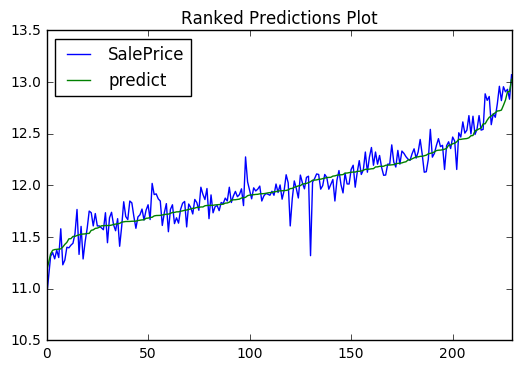

In [24]:
glm2 = glm_grid(encoded_combined_nums, 'SalePrice', base_train, base_valid)

## Train combiner model on second level data

#### Add prediction features to second level data and test data

In [25]:
stack_train = stack_train.cbind(glm0.predict(stack_train))
stack_valid = stack_valid.cbind(glm0.predict(stack_valid))
stack_train = stack_train.cbind(glm1.predict(stack_train))
stack_valid = stack_valid.cbind(glm1.predict(stack_valid))
stack_train = stack_train.cbind(glm2.predict(stack_train))
stack_valid = stack_valid.cbind(glm2.predict(stack_valid))

test = test.cbind(glm0.predict(test))
test = test.cbind(glm1.predict(test))
test = test.cbind(glm2.predict(test))

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


#### Train stack model

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0     [0.5]  Grid_GLM_py_309_sid_83be_model_python_1496514712697_4_model_2   
1    [0.25]  Grid_GLM_py_309_sid_83be_model_python_1496514712697_4_model_1   
2    [0.99]  Grid_GLM_py_309_sid_83be_model_python_1496514712697_4_model_3   
3    [0.01]  Grid_GLM_py_309_sid_83be_model_python_1496514712697_4_model_0   

    residual_deviance  
0  3.1519700019102137  
1   3.170200847683094  
2  3.2418170221136458  
3  3.7533518521134157  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_309_sid_83be_model_python_1496514712697_4_model_2
GLM Model: summary



,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,gaussian,identity,"Elastic Net (alpha = 0.5, lambda = 0.0268 )","nlambda = 100, lambda.max = 0.7285, lambda.min = 0.0268, lambda.1se = -1.0",3152,36,0,py_309_sid_83be




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.012849581983522769
RMSE: 0.11335599668091129
MAE: 0.08084836723572007
RMSLE: 0.008823943897104343
R^2: 0.9158853521674389
Mean Residual Deviance: 0.012849581983522769
Null degrees of freedom: 496
Residual degrees of freedom: 460
Null deviance: 75.92306941024773
Residual deviance: 6.386242245810816
AIC: -677.7337653162446

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 0.013764061143712723
RMSE: 0.11732033559324966
MAE: 0.0896066113781468
RMSLE: 0.009173001742446564
R^2: 0.9270598939149977
Mean Residual Deviance: 0.013764061143712723
Null degrees of freedom: 228
Residual degrees of freedom: 192
Null deviance: 43.21927170266359
Residual deviance: 3.1519700019102137
AIC: -255.55015765929846
Scoring History: 


,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-06-03 14:33:52,0.000 sec,0,.7E0,3,0.1436302,0.1772960
,2017-06-03 14:33:52,0.020 sec,0,.66E0,3,0.1342335,0.1654383
,2017-06-03 14:33:52,0.039 sec,0,.63E0,3,0.1255111,0.1544090
,2017-06-03 14:33:52,0.058 sec,0,.6E0,3,0.1174006,0.1441296
,2017-06-03 14:33:52,0.077 sec,0,.58E0,3,0.1098775,0.1345730
---,---,---,---,---,---,---,---
,2017-06-03 14:33:54,2.510 sec,0,.88E-2,76,0.0099567,0.0150375
,2017-06-03 14:33:55,2.551 sec,0,.84E-2,81,0.0098639,0.0151356
,2017-06-03 14:33:55,2.590 sec,0,.8E-2,82,0.0097584,0.0152665
,2017-06-03 14:33:55,2.625 sec,0,.76E-2,84,0.0096536,0.0154013



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.7906,11.8964
11.9117,11.9742
11.9767,11.9817
11.8451,11.7998
11.1346,11.3061
11.8845,11.9415
11.9382,11.8829
11.8565,11.7301
11.9704,12.0702
12.6667,12.5792


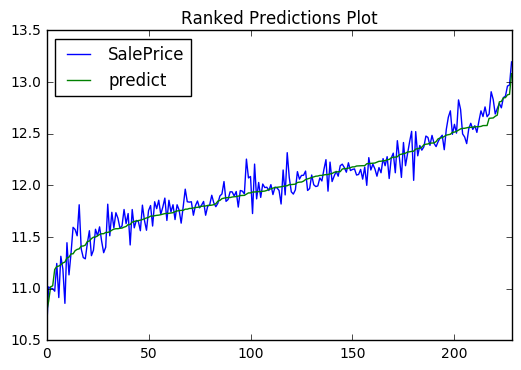

In [26]:
glm3 = glm_grid(encoded_combined_nums + ['predict', 'predict0', 'predict1'], 'SalePrice', stack_train, stack_valid)

#### Score test data

In [27]:
sub = test['Id'].cbind(glm3.predict(test))
sub['predict'] = sub['predict'].exp()
print(sub.head())

glm prediction progress: |████████████████████████████████████████████████| 100%


Id,predict
1461,109333
1462,146004
1463,163835
1464,184214
1465,201909
1466,162035
1467,176115
1468,159432
1469,180660
1470,113283


#### Create submission

In [28]:
# create time stamp
import re
import time
time_stamp = re.sub('[: ]', '_', time.asctime())

# save file for submission
sub.columns = ['Id', 'SalePrice']
sub_fname = '../data/submission_' + str(time_stamp) + '.csv'
h2o.download_csv(sub, sub_fname)

In [29]:
# Shutdown H2O - this will erase all your unsaved frames and models in H2O
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? y
H2O session _sid_83be closed.
